In [1]:
import os
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tabulate import tabulate
np.set_printoptions(threshold=np.inf)



img46-Mouth
width_object: 140, height_object: 42

img47-Mouth
width_object: 140, height_object: 42


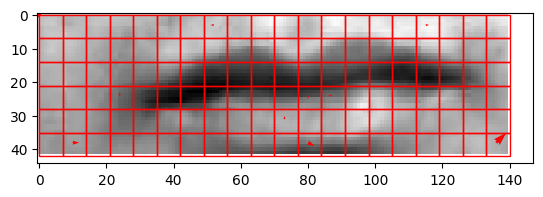


img48-Mouth
width_object: 140, height_object: 42


d:\PCVK-DLIB-KNN\feature_extraction\get_quadran.py:13: RuntimeWarning: invalid value encountered in cast
  Y = np.int_(self.dataB[i])
d:\PCVK-DLIB-KNN\feature_extraction\get_quadran.py:12: RuntimeWarning: invalid value encountered in cast
  X = np.int_(self.dataA[i])


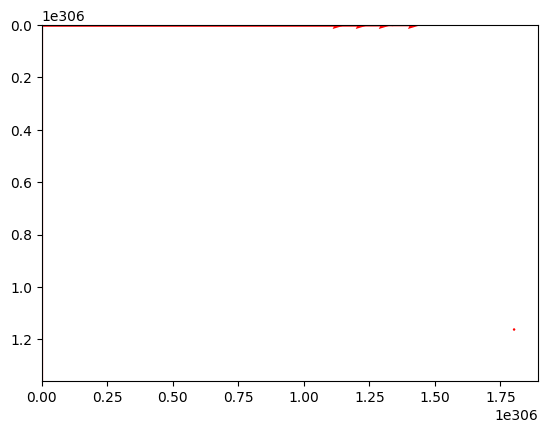


img49-Mouth
width_object: 140, height_object: 42


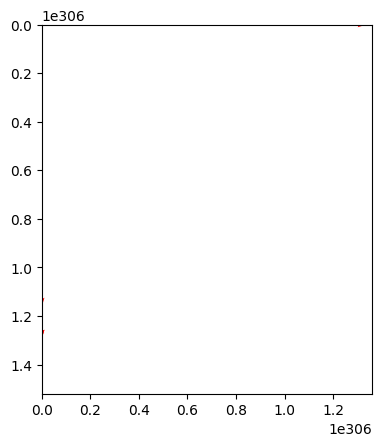


img50-Mouth
width_object: 140, height_object: 42


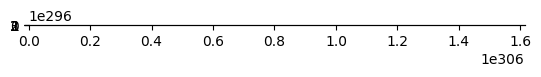


img51-Mouth
width_object: 140, height_object: 42


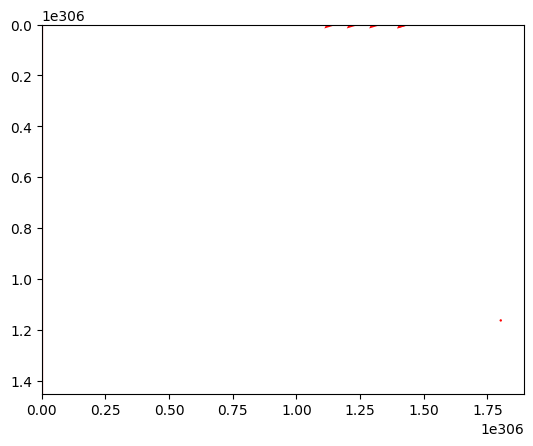


img52-Mouth
width_object: 140, height_object: 42


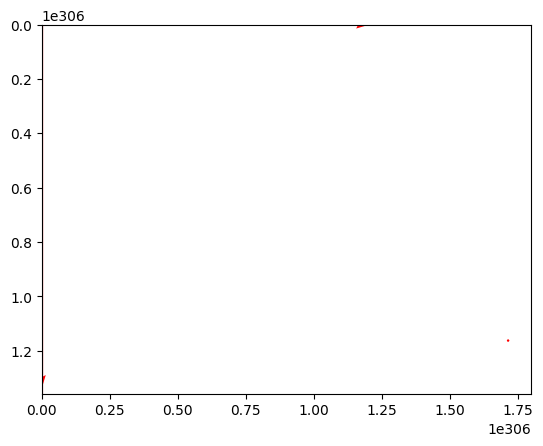


img53-Mouth
width_object: 140, height_object: 42


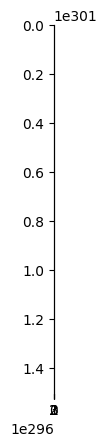


img54-Mouth
width_object: 140, height_object: 42


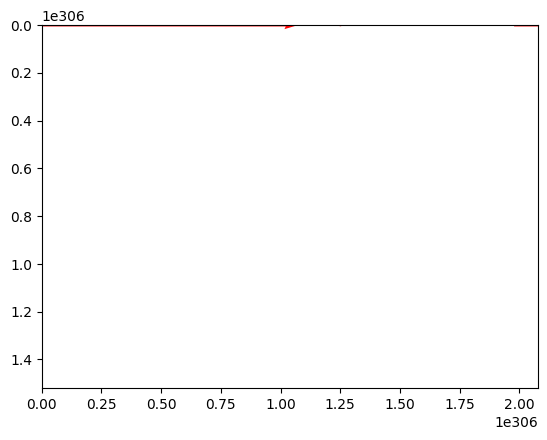


img55-Mouth
width_object: 140, height_object: 42


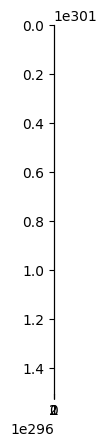


img56-Mouth
width_object: 140, height_object: 42


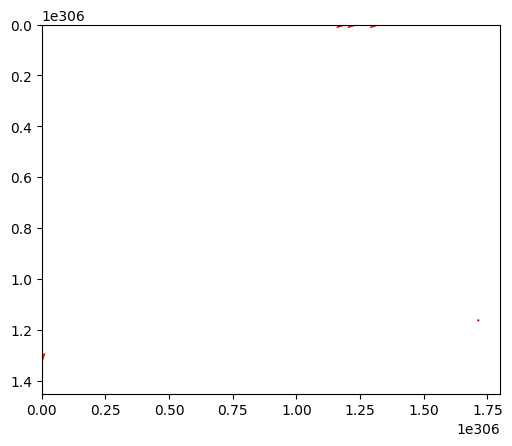


img57-Mouth
width_object: 140, height_object: 42


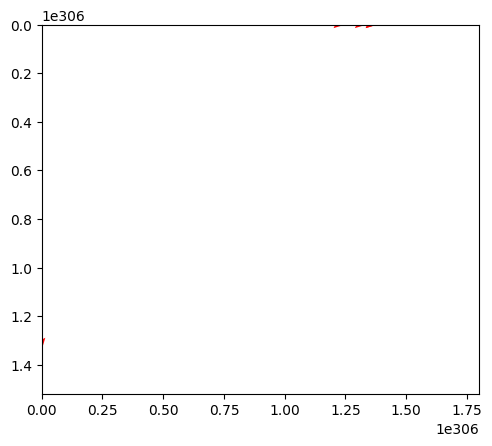


img58-Mouth
width_object: 140, height_object: 42


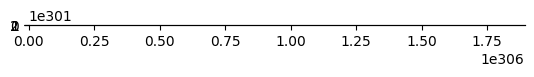


img59-Mouth
width_object: 140, height_object: 42


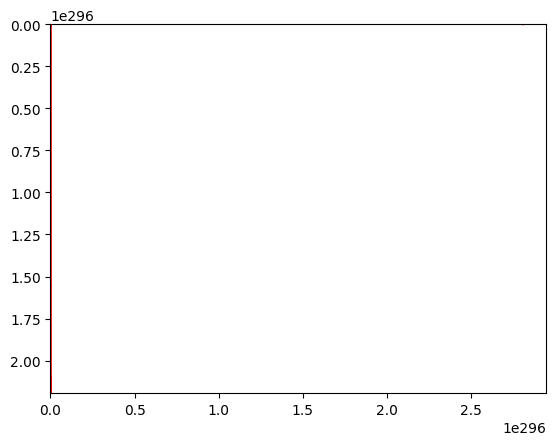


img60-Mouth
width_object: 140, height_object: 42


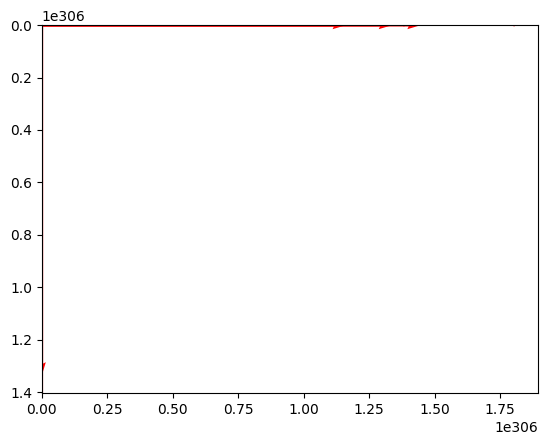


img61-Mouth
width_object: 140, height_object: 42


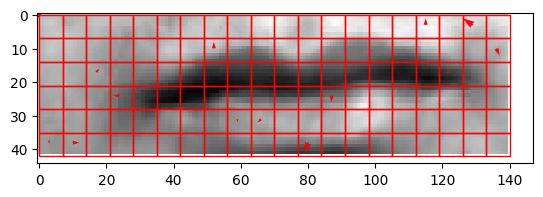


img62-Mouth
width_object: 140, height_object: 42


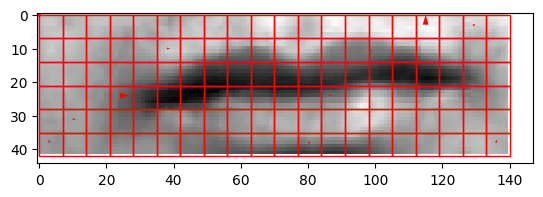


img63-Mouth
width_object: 140, height_object: 42


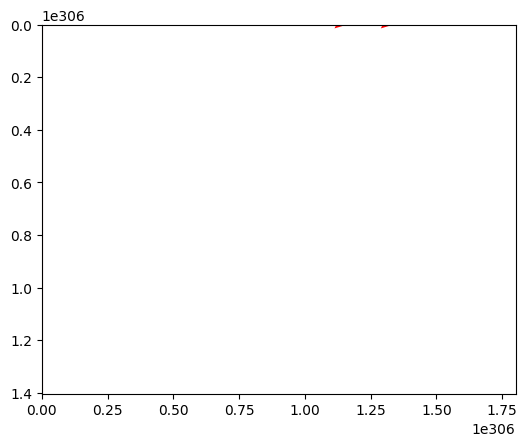


img64-Mouth
width_object: 140, height_object: 42


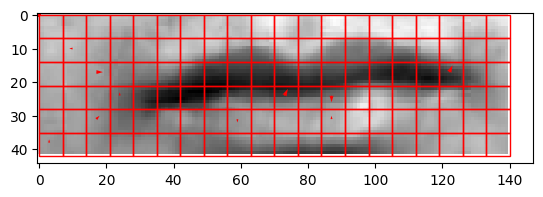


img65-Mouth
width_object: 140, height_object: 42


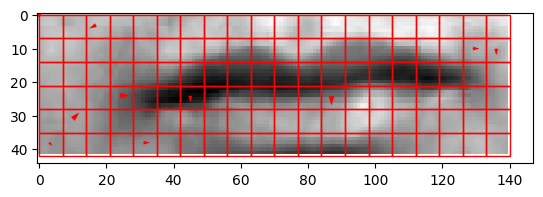


img66-Mouth
width_object: 140, height_object: 42


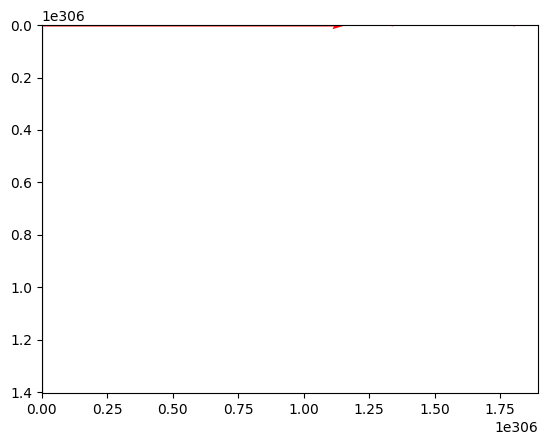


img67-Mouth
width_object: 140, height_object: 42


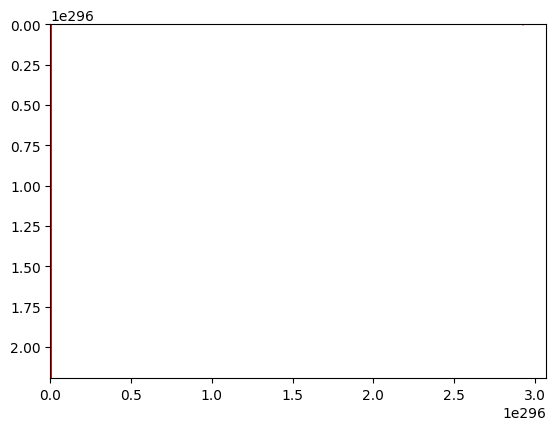


img68-Mouth
width_object: 140, height_object: 42


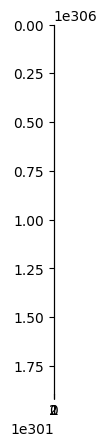


img69-Mouth
width_object: 140, height_object: 42


d:\PCVK-DLIB-KNN\feature_extraction\get_quadran.py:16: RuntimeWarning: invalid value encountered in sqrt
  magnitude = np.sqrt(np.power(X,2) + np.power(Y,2))


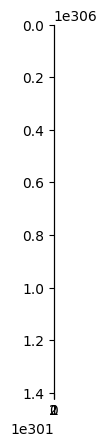


img70-Mouth
width_object: 140, height_object: 42


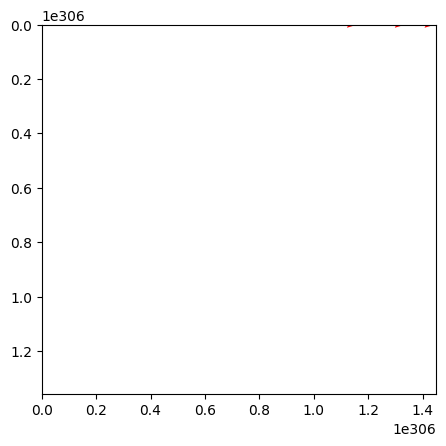


img71-Mouth
width_object: 140, height_object: 42


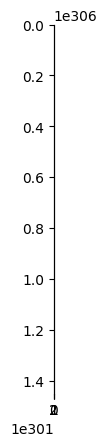


img72-Mouth
width_object: 140, height_object: 42


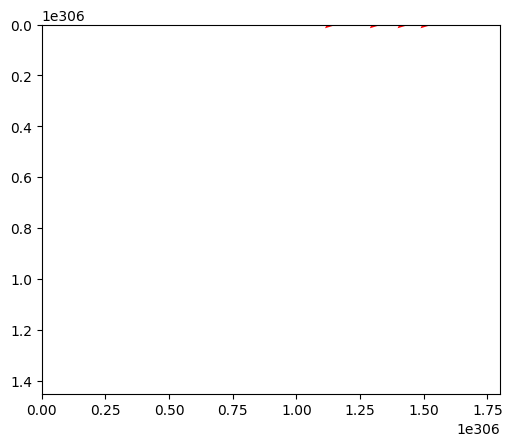


img73-Mouth
width_object: 140, height_object: 42


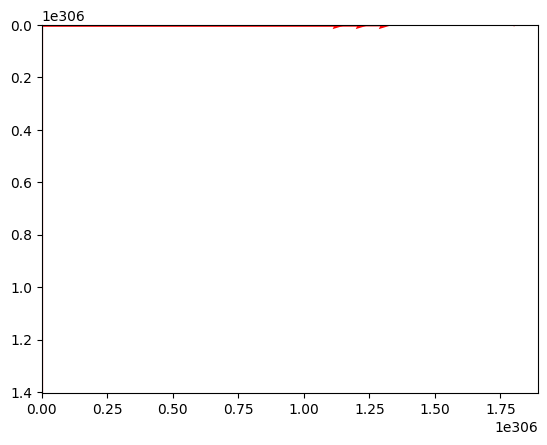


img74-Mouth
width_object: 140, height_object: 42


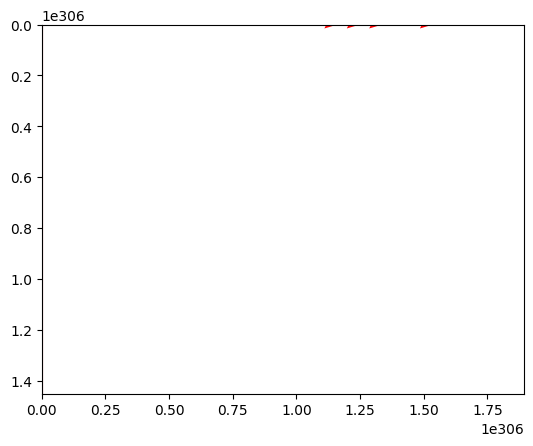


img75-Mouth
width_object: 140, height_object: 42


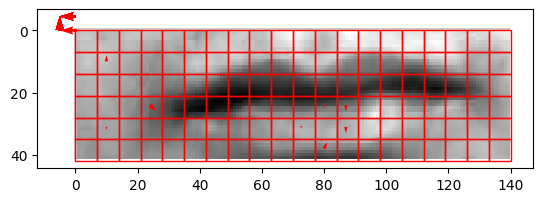


img76-Mouth
width_object: 140, height_object: 42


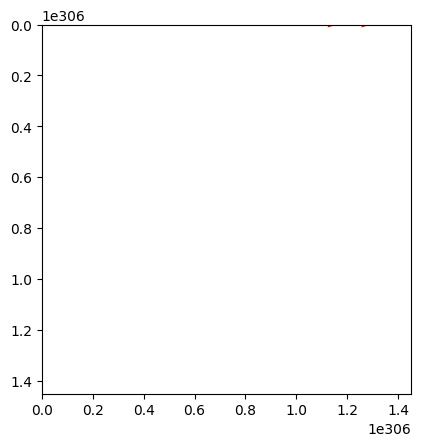


img77-Mouth
width_object: 140, height_object: 42


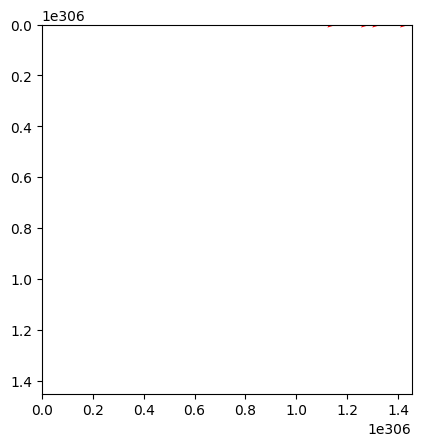


img78-Mouth
width_object: 140, height_object: 42


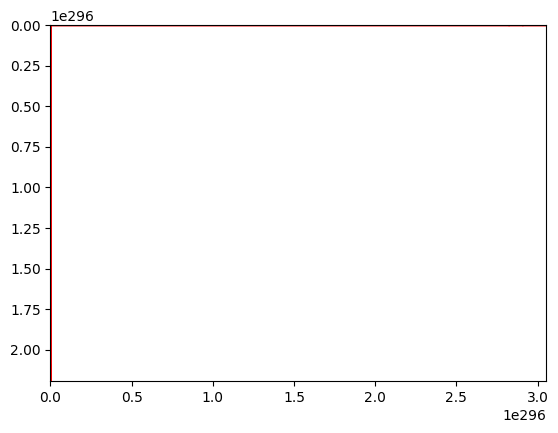


img79-Mouth
width_object: 140, height_object: 42


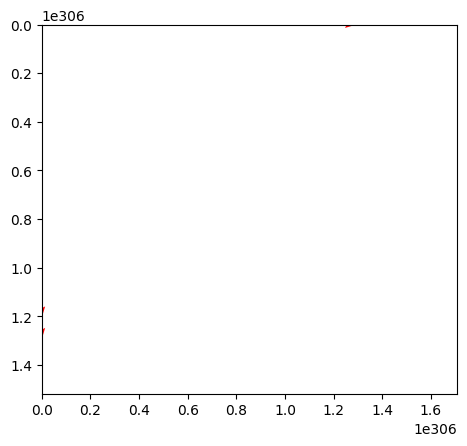


img80-Mouth
width_object: 140, height_object: 42


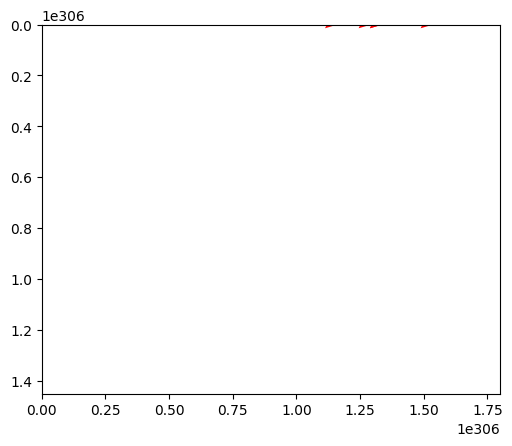


img81-Mouth
width_object: 140, height_object: 42


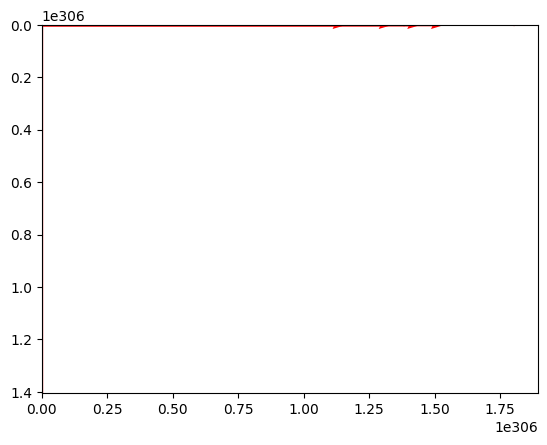


img82-Mouth
width_object: 140, height_object: 42


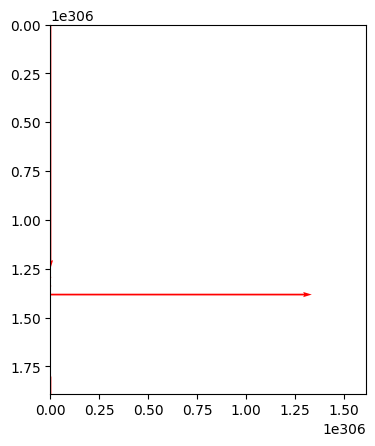


img83-Mouth
width_object: 140, height_object: 42


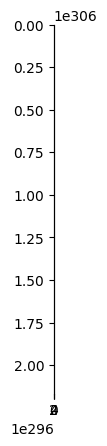


img84-Mouth
width_object: 140, height_object: 42


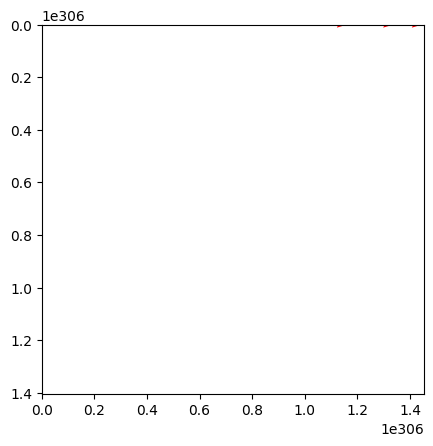


img85-Mouth
width_object: 140, height_object: 42


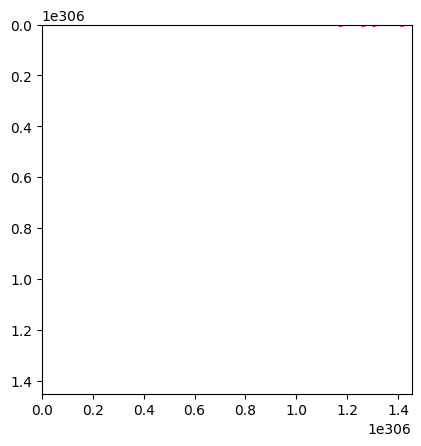


img86-Mouth
width_object: 140, height_object: 42


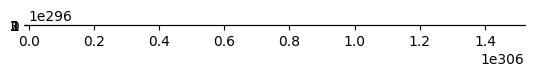

In [2]:
# Import module yang digunkaan untuk ekstrak gambar
from preprocessing.input_to_image import get_frames_by_input_video
from preprocessing.scarpping_component import extract_component_by_images

from feature_extraction.poc import POC as POC
from feature_extraction.get_vektor import getVektor as Vect
from feature_extraction.get_quadran import getQuadran as Qd

# load the face detector and shape predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("models/shape_predictor_68_face_landmarks.dat")
# pathDatasetImage = "dataset/video_to_images"
pathDatasetImage = "dataset/sub01/EP02_01f"
blockSize = 7
# Inisialisasi variabel untuk menampung data pertama
data_blocks_first_image = None
index = 0
# looping semua file yang ada didalam
for filename in os.listdir(pathDatasetImage):
    if filename.endswith(".jpg") or filename.endswith(".png"): 
        # Create the directory if it doesn't exist
        image = cv2.imread(os.path.join(pathDatasetImage, filename))
        image = cv2.resize(image, (600, 500))
        # image = cv2.resize(image, (98, 56))
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # detect the faces
        rects = detector(gray)

        # go through the face bounding boxes
        for rect in rects:
            # apply the shape predictor to the face ROI
            shape = predictor(gray, rect)

            # Mata Kiri
            data_blocks_image_current = np.array(extract_component_by_images(
                image=image, 
                shape=shape, 
                frameName=filename.split(".")[0],
                objectName="mouth", 
                objectRectangle={"x_right": 54, "x_left": 48, "y_highest": 52, "y_lowest": 57}, 
                pixelShifting={"pixel_x": 25, "pixel_y": 5}
            ))

            # Sprint(data_blocks_image_current)
            # Ambil data pertama untuk pembanding di rumus pocnya
            if data_blocks_first_image is None:
                data_blocks_first_image = data_blocks_image_current
                continue

            plt.imshow(np.uint8((data_blocks_first_image*0.9) + (data_blocks_image_current*0.1)), cmap="gray")

            # Inisiasi class POC
            initPOC = POC(data_blocks_first_image, data_blocks_image_current, blockSize) 
            # Pemanggilan fungsi pocCalc() untuk menghitung nilai POC disetiap gambar
            valPOC = initPOC.getPOC() 

            # Pemanggilan class dan method untuk menampilkan quiver / gambar panah
            initQuiv = Vect(valPOC, blockSize)
            quivData = initQuiv.createVektor() 

            plt.quiver(quivData[:, 0], quivData[:, 1], quivData[:, 2], quivData[:, 3], scale=1, scale_units='xy', angles='xy', color="r")    

            # num = 0
            for rect_def in valPOC[2]:
                x, y, width, height = rect_def
                
                rects = patches.Rectangle((x,y), width,height, edgecolor='r', facecolor='none') 
                plt.gca().add_patch(rects)
                
                # plt.text(x,y,f'({num})', color="blue") 
                # num += 1

            # Pemanggilan class untuk mengeluarkan nilai karakteristik vektor
            # blok ke, x,y,tetha, magnitude, dan quadran ke
            initQuadran = Qd(quivData)
            quadran = initQuadran.setQuadran()

            # print(tabulate(quadran, headers=['Blok Ke', 'X', 'Y', 'Tetha', 'Magnitude', 'Quadran Ke']))
            plt.axis('on')  # Matikan sumbu
            plt.show()       

# print("ini frame awal 46")
# print(data_blocks_first_image)

# cv2.imshow("Frame", image)
# cv2.waitKey(0)